## Character-level recurrent sequence-to-sequence model

Example from https://keras.io/examples/nlp/lstm_seq2seq/  
Older post https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

In [1]:
import numpy as np
import pandas as pd
import pydot as pyd
from itertools import chain

from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [3]:
with np.load('data/ncbi_02/dataset.npz', allow_pickle = True) as data:
    encoder_input_data = data['encoder_input_data']
    decoder_input_data = data['decoder_input_data']
    decoder_target_data = data['decoder_target_data']
    token_index = data['token_index'].tolist()

In [4]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)
print(token_index)

(4368, 3822, 4)
(4368, 3822, 4)
(4368, 3822, 4)
{'A': 0, 'C': 1, 'G': 2, 'T': 3}


In [5]:
X_data = encoder_input_data[:100]
Y_data = decoder_input_data[:100]
print("X_data", X_data.shape)
print("Y_data", Y_data.shape)

X_data (100, 3822, 4)
Y_data (100, 3822, 4)


In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16628062280452968056
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7283867648
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 10526430679040405781
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7741702144
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 14409166121081046679
physical_device_desc: "device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


2021-11-11 17:38:45.947889: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-11 17:38:46.100624: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 17:38:46.101015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 17:38:46.105149: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Construct model

In [7]:
latent_dim = 128     # Latent dimensionality of the encoding space.

In [8]:
input_train = Input(shape=(X_data.shape[1], X_data.shape[2]))
output_train = Input(shape=(Y_data.shape[1], Y_data.shape[2]))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [10]:
encoder_last_h, encoder_last_c = GRU(
    latent_dim, dropout = 0.05, recurrent_dropout = 0.05, # , activation = 'elu'
    return_sequences = False, return_state = True)(input_train)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gru_1/strided_slice_3:0', description="created by layer 'gru_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gru_1/while:4', description="created by layer 'gru_1'")


In [11]:
encoder_last_h = BatchNormalization(momentum = 0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum = 0.6)(encoder_last_c)

In [12]:
decoder = RepeatVector(Y_data.shape[1])(encoder_last_h)
decoder = GRU(
    latent_dim, dropout = 0.05, recurrent_dropout = 0.05, # , activation = 'elu'
    return_state = False, return_sequences = True)(
    decoder, initial_state = encoder_last_h)
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 128), dtype=tf.float32, name=None), name='gru_2/transpose_1:0', description="created by layer 'gru_2'")


In [13]:
out = TimeDistributed(Dense(Y_data.shape[2], activation = "softmax"))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 3822, 4), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [14]:
model = Model(inputs = input_train, outputs = out)
opt = keras.optimizers.Adam(learning_rate = 0.01, clipnorm = 1)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3822, 4)]    0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     [(None, 128), (None, 51456       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         gru_1[0][0]                      
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 3822, 128)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

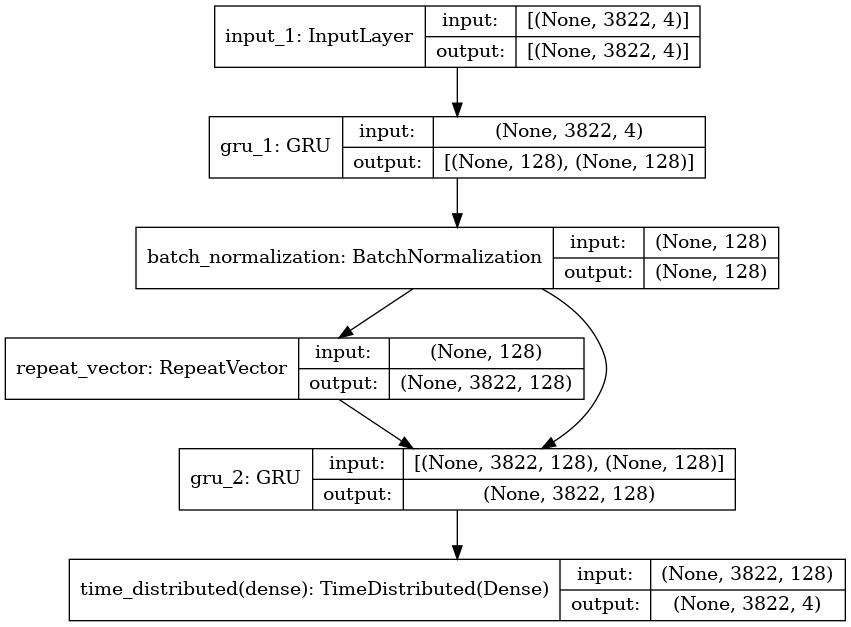

In [15]:
keras.utils.plot_model(model, to_file = 'model_plot.png', show_shapes = True, show_layer_names = True)

## Train model

In [16]:
batch_size = 128      # Batch size for training.
patience = 10        # Patience for EarlyStop
epochs = 1000        # Number of epochs to train for.

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience, restore_best_weights = True)
history = model.fit(X_data, Y_data, validation_split = 0.2, 
                    epochs = epochs, verbose = 1, callbacks = [ es ], 
                    batch_size = batch_size)
train_mae = history.history['accuracy']
valid_mae = history.history['val_accuracy']

2021-11-11 17:39:05.962837: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/1000


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

0 next 291560
2021-11-11 17:39:26.409198: I tensorflow/core/common_runtime/bfc_allocator.cc:1060] InUse at 7f2bc3741900 of size 40960 next 291562
2021-11-11 17:39:26.409201: I tensorflow/core/common_runtime/bfc_allocator.cc:1060] InUse at 7f2bc374b900 of size 40960 next 291563
2021-11-11 17:39:26.409204: I tensorflow/core/common_runtime/bfc_allocator.cc:1060] InUse at 7f2bc3755900 of size 40960 next 291571
2021-11-11 17:39:26.409207: I tensorflow/core/common_runtime/bfc_allocator.cc:1060] InUse at 7f2bc375f900 of size 40960 next 291572
2021-11-11 17:39:26.409210: I tensorflow/core/common_runtime/bfc_allocator.cc:1060] InUse at 7f2bc3769900 of size 40960 next 29156

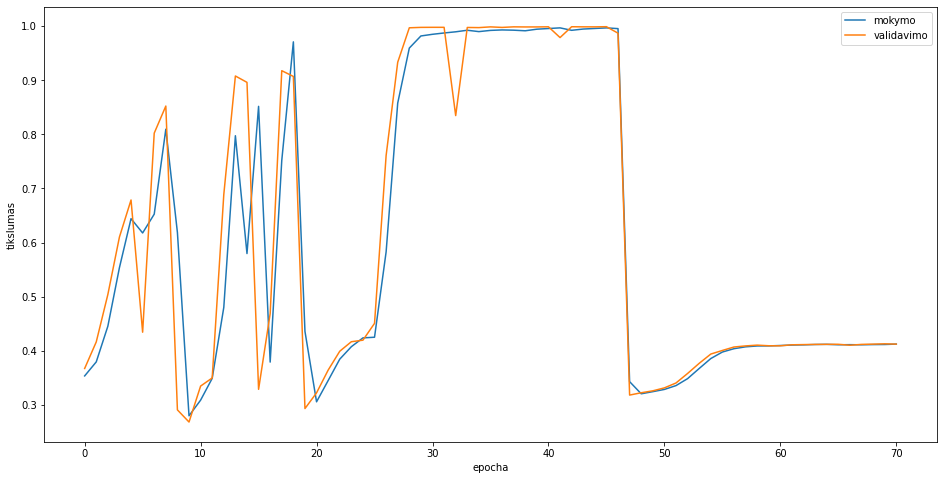

In [12]:
plt.plot(log.history['accuracy'], label = 'mokymo')
plt.plot(log.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.show()

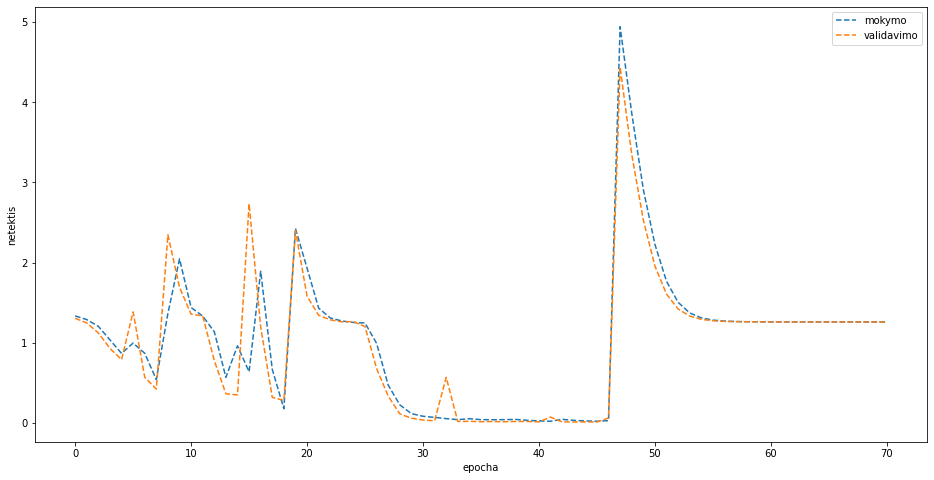

In [13]:
plt.plot(log.history['loss'], '--', label = 'mokymo')
plt.plot(log.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.show()

In [14]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

# Save model
model.save("data/ncbi_02/model_256")

2021-10-05 17:23:55.442611: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: data/ncbi_02/model_256/assets


INFO:tensorflow:Assets written to: data/ncbi_02/model_256/assets
